# LLM Proofreader Report — Summary

This notebook summarises the **LLM proofreader** outputs and produces:

- A **per-file** breakdown of errors (including errors per page)
- A **per-subject** breakdown of errors (including errors per 100 pages)

## Inputs
- `notebooks/cleansed_data/llm_proofreader_cleansed_data.csv`
- `notebooks/cleansed_data/document_stats-files.csv`

## Filtering
The report contains a `Likely False Positive` column. This notebook filters out rows where that column indicates a likely false positive, so only **true errors** are included in summaries.

## Dependencies and display settings

Set display options and import libraries used in the notebook.

In [1]:
from __future__ import annotations

from pathlib import Path

import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)

## Locate repository and load data

Find repository root and load the proofreader and document stats CSVs.

In [2]:
def find_repo_root(start: Path) -> Path:
    """Find repo root by walking up until pyproject.toml is found."""
    current = start.resolve()
    for _ in range(8):
        if (current / "pyproject.toml").exists():
            return current
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError("Could not locate repo root (pyproject.toml)")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_DIR = REPO_ROOT / "notebooks" / "cleansed_data"

llm_path = DATA_DIR / "llm_proofreader_cleansed_data.csv"
docs_path = DATA_DIR / "document_stats-files.csv"

df_raw = pd.read_csv(llm_path)
docs = pd.read_csv(docs_path)

print("Repo root:", REPO_ROOT)
print("Loaded proofreader rows:", len(df_raw))
print("Loaded doc stats rows:", len(docs))
df_raw.head()

Repo root: /workspaces/WjecDocumentScraper
Loaded proofreader rows: 15673
Loaded doc stats rows: 239


,Subject,Filename,issue_id,page_number,Issue,Context,pass_code,Error Category,confidence_score,Reasoning,Likely False Positive
0,Art-and-Design,art-and-design---option-evening-flyer.csv,0,0,during a during a,You will undertake contextual and practical re...,LPR,Grammar,100,The phrase 'during a' is repeated unnecessaril...,False
1,Art-and-Design,art-and-design---option-evening-flyer.csv,1,0,learn and understand about working independently,You will also **learn and understand about wor...,LPR,Stylistic,80,The phrasing 'learn and understand about worki...,False
2,Art-and-Design,art-and-design---option-evening-flyer.csv,2,0,Film researcher,"Fashion Designer, Fine Artist, **Film research...",LPR,Consistency,95,The term 'Film researcher' is inconsistently c...,False
3,Art-and-Design,art-and-design---option-evening-flyer.csv,3,0,Jewellery designer,"Interior Designer, Illustrator, **Jewellery de...",LPR,Consistency,95,The term 'Jewellery designer' is inconsistentl...,False
4,Art-and-Design,art-and-design---option-evening-flyer.csv,4,0,Knitwear designer,"Illustrator, Jewellery designer, **Knitwear de...",LPR,Consistency,95,The term 'Knitwear designer' is inconsistently...,False


## Filter likely false positives

Convert the 'Likely False Positive' column to boolean-ish values and remove true positives from the dataset.

In [3]:
# Filter to true errors by excluding likely false positives
df = df_raw.copy()

lfp_col = "Likely False Positive"
if lfp_col not in df.columns:
    raise KeyError(f"Missing expected column: {lfp_col!r}. Available: {list(df.columns)}")

def to_boolish(value) -> bool | None:
    if pd.isna(value):
        return None
    if isinstance(value, bool):
        return value
    text = str(value).strip().lower()
    if text in {"true", "t", "yes", "y", "1"}:
        return True
    if text in {"false", "f", "no", "n", "0"}:
        return False
    return None

df["likely_false_positive"] = df[lfp_col].map(to_boolish)

before = len(df)
df = df[df["likely_false_positive"] != True].copy()  # keep False/None
after = len(df)

print(f"Rows before filter: {before:,}")
print(f"Rows after filter (true errors): {after:,}")
print("Filtered out as likely false positives:", before - after)

for col in ["page_number", "issue_id", "confidence_score"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.head()

Rows before filter: 15,673
Rows after filter (true errors): 14,856
Filtered out as likely false positives: 817


,Subject,Filename,issue_id,page_number,Issue,Context,pass_code,Error Category,confidence_score,Reasoning,Likely False Positive,likely_false_positive
0,Art-and-Design,art-and-design---option-evening-flyer.csv,0,0,during a during a,You will undertake contextual and practical re...,LPR,Grammar,100,The phrase 'during a' is repeated unnecessaril...,False,False
1,Art-and-Design,art-and-design---option-evening-flyer.csv,1,0,learn and understand about working independently,You will also **learn and understand about wor...,LPR,Stylistic,80,The phrasing 'learn and understand about worki...,False,False
2,Art-and-Design,art-and-design---option-evening-flyer.csv,2,0,Film researcher,"Fashion Designer, Fine Artist, **Film research...",LPR,Consistency,95,The term 'Film researcher' is inconsistently c...,False,False
3,Art-and-Design,art-and-design---option-evening-flyer.csv,3,0,Jewellery designer,"Interior Designer, Illustrator, **Jewellery de...",LPR,Consistency,95,The term 'Jewellery designer' is inconsistentl...,False,False
4,Art-and-Design,art-and-design---option-evening-flyer.csv,4,0,Knitwear designer,"Illustrator, Jewellery designer, **Knitwear de...",LPR,Consistency,95,The term 'Knitwear designer' is inconsistently...,False,False


## Join proofreader data to document stats

Match proofreader filenames to document stats (page counts) and report any missing page counts.

In [4]:
# Join proofreader data to per-file page counts
# Note: proofreader filenames end with .csv, while document_stats uses .md.
docs = docs.copy()
docs["Pages"] = pd.to_numeric(docs["Pages"], errors="coerce")

df["document_filename"] = df["Filename"].astype(str)
mask_csv = df["document_filename"].str.endswith(".csv", na=False)
df.loc[mask_csv, "document_filename"] = df.loc[mask_csv, "document_filename"].str.replace(".csv", ".md", regex=False)

docs = docs.rename(columns={"Filename": "document_filename"})

df_joined = df.merge(
    docs[["Subject", "document_filename", "Pages"]],
    on=["Subject", "document_filename"],
    how="left",
)

missing_pages = df_joined[df_joined["Pages"].isna()][["Subject", "Filename", "document_filename"]].drop_duplicates()
print("Rows missing page counts after join:", int(df_joined["Pages"].isna().sum()))
print("Unique (Subject, File) missing page counts:", len(missing_pages))
missing_pages.head(20)

Rows missing page counts after join: 0
Unique (Subject, File) missing page counts: 0


,Subject,Filename,document_filename


## Per-file breakdown of (true) errors

Compute total errors and errors per page for each document file.

In [14]:
# Per-file breakdown of (true) errors — only show errors per page (rounded to 1dp)
import numpy as np
per_file = (
    df_joined
    .groupby(["Subject", "document_filename"], dropna=False)
    .agg(
        errors=("issue_id", "count"),
        pages=("Pages", "max"),
    )
    .reset_index()
)

# Compute errors per page, guard against infinite values and round to 1 decimal place
per_file["errors_per_page"] = (
    (per_file["errors"] / per_file["pages"]).replace([np.inf, -np.inf], pd.NA).round(1)
)

# Rename errors to total_errors, sort by Subject then document name and display identifier columns + totals
per_file = per_file.rename(columns={"errors": "total_errors"})
per_file = per_file.sort_values(["Subject", "document_filename"])[["Subject", "document_filename", "total_errors", "errors_per_page"]]
per_file.head(30)

,Subject,document_filename,total_errors,errors_per_page
0,Art-and-Design,art-and-design---option-evening-flyer.md,8,4.0
1,Art-and-Design,gcse-art-and-design---delivery-guide.md,13,0.9
2,Art-and-Design,gcse-art-and-design---faqs.md,5,1.2
3,Art-and-Design,gcse-art-and-design---guidance-for-teaching.md,235,3.3
4,Art-and-Design,gcse-art-and-design---unit-1-non-exam-assessme...,44,1.9
5,Art-and-Design,gcse-art-and-design---unit-2-externally-set-as...,104,2.7
6,Art-and-Design,overview-of-consultation-findings.md,104,4.5
7,Art-and-Design,wjec-gcse-art-and-design-specification.md,74,2.8
8,Business,gcse-business---delivery-guide.md,94,4.9
9,Business,gcse-business---faqs.md,23,4.6


## Per-subject breakdown

Aggregate errors and pages at subject level and compute errors per 100 pages.

In [6]:
# Per-subject breakdown (using document_stats for total pages per subject)
subject_total_pages = (
    docs.groupby("Subject", dropna=False)
    .agg(total_pages=("Pages", "sum"), total_files=("document_filename", "nunique"))
    .reset_index()
)

subject_errors = (
    per_file
    .groupby("Subject", dropna=False)
    .agg(
        errors=("errors", "sum"),
        files_with_errors=("document_filename", "nunique"),
        pages_with_errors=("pages", "sum"),
    )
    .reset_index()
)

per_subject = subject_total_pages.merge(subject_errors, on="Subject", how="left")
per_subject = per_subject.fillna({"errors": 0, "files_with_errors": 0, "pages_with_errors": 0})

per_subject["errors_per_100_pages"] = (per_subject["errors"] / per_subject["total_pages"]) * 100
per_subject["files_with_errors_pct"] = (per_subject["files_with_errors"] / per_subject["total_files"]) * 100

per_subject = per_subject.sort_values(["errors", "errors_per_100_pages"], ascending=[False, False])
per_subject.head(50)

,Subject,total_pages,total_files,errors,files_with_errors,pages_with_errors,errors_per_100_pages,files_with_errors_pct
1,Business,422,13,1909,13,422,452.369668,100.0
2,Computer-Science,344,10,1740,10,344,505.813953,100.0
7,Drama,539,13,1623,13,539,301.113173,100.0
14,History,1184,35,1400,35,1184,118.243243,100.0
20,Religious-Studies,788,14,1250,14,788,158.629442,100.0
12,German,438,13,855,13,438,195.205479,100.0
8,English-Language-and-Literature,793,22,834,22,793,105.170240,100.0
11,Geography,501,20,772,18,498,154.091816,90.0
9,Food-and-Nutrition,484,19,697,19,484,144.008264,100.0
10,French,437,13,598,13,437,136.842105,100.0


## Errors by subject and category

Create a pivot table of errors by subject and error category.

In [7]:
# Subject x category breakdown
subject_category = (
    df_joined
    .groupby(["Subject", "Error Category"], dropna=False)
    .size()
    .rename("errors")
    .reset_index()
)

subject_category_pivot = (
    subject_category
    .pivot_table(index="Subject", columns="Error Category", values="errors", fill_value=0, aggfunc="sum")
    .sort_values(by="Subject")
)

subject_category_pivot.head(30)

Error Category,Ambiguous Phrasing,Consistency,Factual,Grammar,Spelling,Stylistic
Subject,,,,,,
Art-and-Design,13,100,8,272,54,140
Business,46,262,49,872,125,555
Computer-Science,47,206,31,855,120,481
Dance,15,50,3,85,13,28
Design-and-Technology,7,39,16,106,40,87
Digital-Media-and-Film,6,11,1,63,11,40
Digital-Technology,5,68,5,114,20,48
Drama,46,191,24,800,115,447
English-Language-and-Literature,20,114,16,384,52,248


## Top files by error rate

Identify files with the highest error rates (requires page counts).

In [8]:
# Top files by error rate (requires page counts)
top_rate = per_file.dropna(subset=["pages"]).copy()
top_rate = top_rate[top_rate["pages"] > 0]
top_rate = top_rate.sort_values("errors_per_10_pages", ascending=False)
top_rate.head(30)

,Subject,document_filename,errors,pages,categories,passes,errors_per_page,errors_per_10_pages
37,Digital-Technology,digital-technology---options-evening-flyer.md,25,2,4,1,12.500000,125.000000
31,Dance,dance---options-evening-flyer.md,21,2,5,1,10.500000,105.000000
33,Design-and-Technology,design-and-technology---options-evening-flyer.md,18,2,3,1,9.000000,90.000000
29,Computer-Science,overview-of-consultation-findings.md,187,23,5,1,8.130435,81.304348
19,Business,overview-of-consultation-findings.md,186,23,6,1,8.086957,80.869565
25,Computer-Science,gcse-computer-science---option-evening-flyer.md,15,2,3,1,7.500000,75.000000
43,Drama,gcse-drama---guidance-for-teaching-unit-3.md,442,61,6,1,7.245902,72.459016
14,Business,gcse-business---option-evening-flyer.md,14,2,3,1,7.000000,70.000000
24,Computer-Science,gcse-computer-science---guidance-for-teaching-...,295,43,6,1,6.860465,68.604651
174,Integrated-Science-Single-Award,september-2025.md,34,5,4,1,6.800000,68.000000


## A small sample of the (true) errors

Display a short sample of true errors for quick inspection.

In [9]:
# A small sample of the (true) errors, for quick inspection
cols = [
    "Subject",
    "document_filename",
    "page_number",
    "Issue",
    "Error Category",
    "pass_code",
    "confidence_score",
    "Context",
    "Reasoning",
]
available_cols = [c for c in cols if c in df_joined.columns]
df_joined[available_cols].head(50)

,Subject,document_filename,page_number,Issue,Error Category,pass_code,confidence_score,Context,Reasoning
0,Art-and-Design,art-and-design---option-evening-flyer.md,0,during a during a,Grammar,LPR,100,You will undertake contextual and practical re...,The phrase 'during a' is repeated unnecessaril...
1,Art-and-Design,art-and-design---option-evening-flyer.md,0,learn and understand about working independently,Stylistic,LPR,80,You will also **learn and understand about wor...,The phrasing 'learn and understand about worki...
2,Art-and-Design,art-and-design---option-evening-flyer.md,0,Film researcher,Consistency,LPR,95,"Fashion Designer, Fine Artist, **Film research...",The term 'Film researcher' is inconsistently c...
3,Art-and-Design,art-and-design---option-evening-flyer.md,0,Jewellery designer,Consistency,LPR,95,"Interior Designer, Illustrator, **Jewellery de...",The term 'Jewellery designer' is inconsistentl...
4,Art-and-Design,art-and-design---option-evening-flyer.md,0,Knitwear designer,Consistency,LPR,95,"Illustrator, Jewellery designer, **Knitwear de...",The term 'Knitwear designer' is inconsistently...
5,Art-and-Design,art-and-design---option-evening-flyer.md,0,Make-up artist,Consistency,LPR,95,"Knitwear designer, Landscape Architect, Lighti...",The term 'Make-up artist' is inconsistently ca...
6,Art-and-Design,art-and-design---option-evening-flyer.md,0,Video artist,Consistency,LPR,95,"Theatre Designer, TV Director, Textile Designe...",The term 'Video artist' is inconsistently capi...
7,Art-and-Design,art-and-design---option-evening-flyer.md,0,-TALK,Stylistic,LPR,90,FIND OUT MORE **-TALK** TO YOUR TEACHER TODAY!,There should be a space after the dash for rea...
8,Art-and-Design,gcse-art-and-design---delivery-guide.md,5,from personal and/or given starting point,Grammar,LPR,95,"- that is internally set, in consultation with...",The phrasing 'from personal and/or given start...
9,Art-and-Design,gcse-art-and-design---delivery-guide.md,5,and/preparatory,Spelling,LPR,95,Learners can have access to resources **and/pr...,This appears to be a typographical error; it s...


## Optional charts

Simple charts for top subjects and files (kept dependency-free using matplotlib).

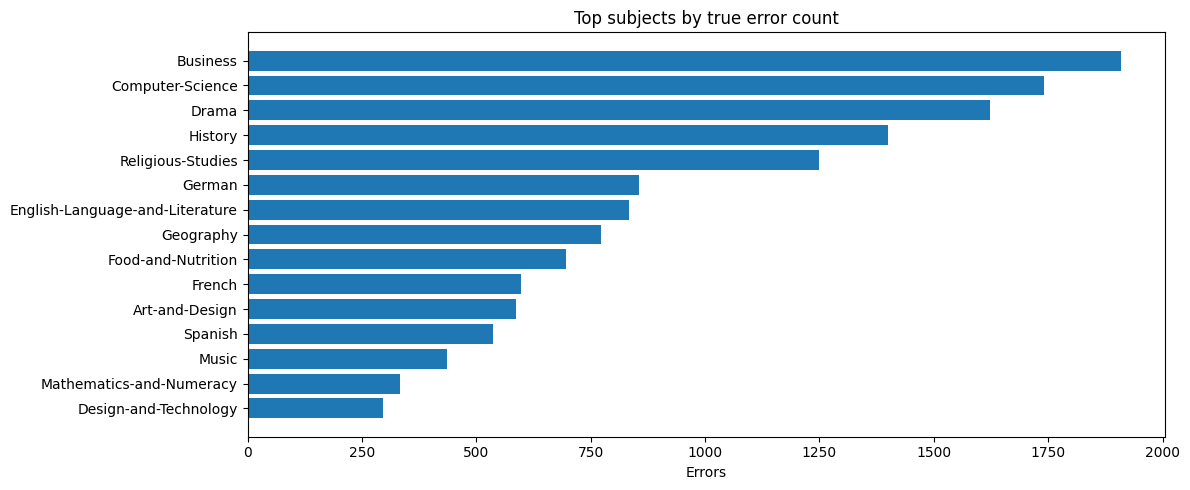

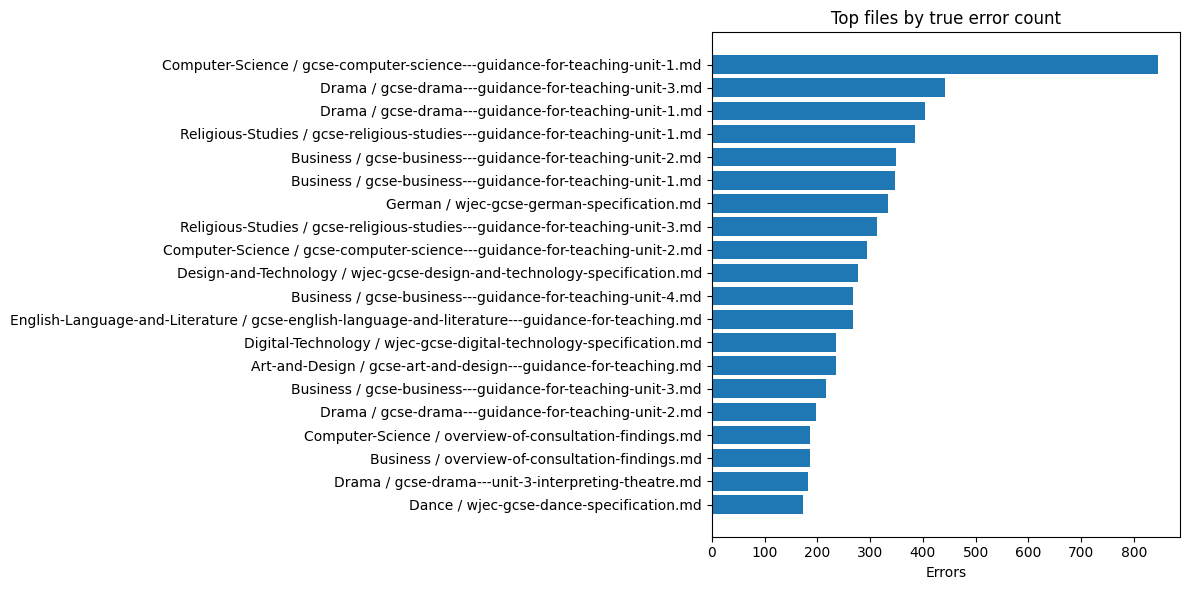

In [10]:
# Optional charts (kept simple and dependency-free)
import matplotlib.pyplot as plt

top_subjects = per_subject.head(15).copy()
plt.figure(figsize=(12, 5))
plt.barh(top_subjects["Subject"], top_subjects["errors"])
plt.gca().invert_yaxis()
plt.title("Top subjects by true error count")
plt.xlabel("Errors")
plt.tight_layout()
plt.show()

top_files = per_file.head(20).copy()
labels = top_files["Subject"] + " / " + top_files["document_filename"]
plt.figure(figsize=(12, 6))
plt.barh(labels, top_files["errors"])
plt.gca().invert_yaxis()
plt.title("Top files by true error count")
plt.xlabel("Errors")
plt.tight_layout()
plt.show()